# The robustness and broad applicability of the STAVER algorithm for disease diagnosis and classification.

To validate the outstanding advantages of the STAVER algorithm for potential clinical decision-making, we comprehensively evaluated the generalization performance and prediction accuracy of classification models constructed based on the above tumor biomarkers. 

To illustrate the robustness and broad applicability of the STAVER algorithm, we constructed three separate benchmark classification models based on different algorithms, including decision tree-based random forest, gradient boosting-based XGBoost, and linear regression-based logistic regression models (Materials and methods section). 

As a result, compared to the original proteomic data, the classification models constructed based on STAVER-processed data exhibited increased generalization performance in distinguishing specific cancer-type cell lines.

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import itertools
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# python matplotlib export editable PDF 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['figure.dpi']= 150

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import warnings
warnings.filterwarnings('ignore')

## Define the DeLong's test function and test it

z score = -0.54622;
p value = 0.58492;
There is NO significant difference
P-value from DeLong's test: 0.58492


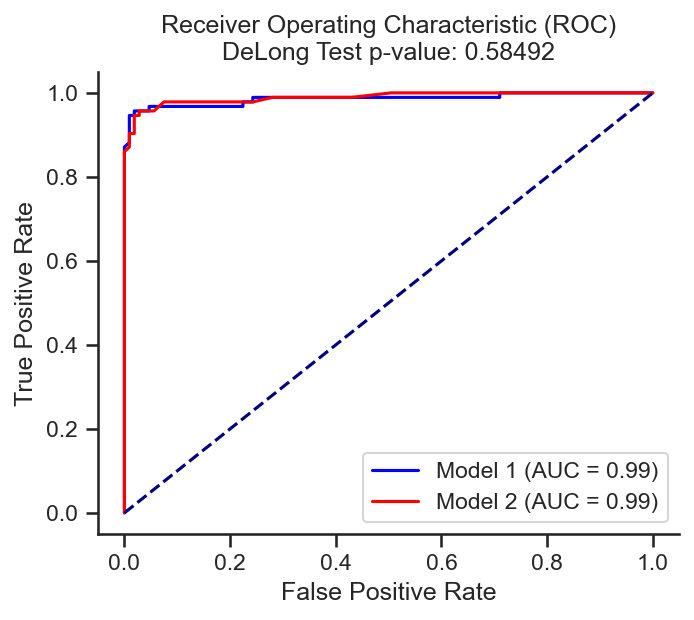

In [3]:
class DelongTest:
    def __init__(self, preds1, preds2, label, threshold=0.05):
        """
        Initialize the Delong Test.

        Args:  
            preds1: Prediction probabilities from the first model.
            preds2: Prediction probabilities from the second model.
            label: Actual labels (ground truth).
            threshold: Significance level for the p-value. Default is 0.05.

        Returns:
            z: The z-score for the two-tailed test.
            p: The p-value for the two-tailed test.
        """
        self._preds1 = preds1
        self._preds2 = preds2
        self._label = label
        self.threshold = threshold
        self.z, self.p = self._compute_z_p()  # Directly compute and store results on initialization
        self._show_result()

    def _auc(self, X, Y):
        """Compute the AUC using the Mann-Whitney statistic."""
        return 1 / (len(X) * len(Y)) * sum([self._kernel(x, y) for x in X for y in Y])

    @staticmethod
    def _kernel(X, Y):
        """Kernel function to compute the Mann-Whitney statistic."""
        return 0.5 if Y == X else int(Y < X)

    def _structural_components(self, X, Y):
        """Compute the structural components used for the covariance calculation."""
        V10 = [1 / len(Y) * sum([self._kernel(x, y) for y in Y]) for x in X]
        V01 = [1 / len(X) * sum([self._kernel(x, y) for x in X]) for y in Y]
        return V10, V01

    def _get_S_entry(self, V_A, V_B, auc_A, auc_B):
        """Calculate an entry of the covariance matrix."""
        return 1 / (len(V_A) - 1) * sum([(a - auc_A) * (b - auc_B) for a, b in zip(V_A, V_B)])

    def _z_score(self, var_A, var_B, covar_AB, auc_A, auc_B):
        """Calculate the z-score for the two-tailed test."""
        return (auc_A - auc_B) / np.sqrt(var_A + var_B - 2 * covar_AB + 1e-8)

    def _group_preds_by_label(self, preds, actual):
        """Group predictions by their actual label."""
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y

    def _compute_z_p(self):
        """Main function to compute the z-score and p-value for the DeLong test."""
        X_A, Y_A = self._group_preds_by_label(self._preds1, self._label)
        X_B, Y_B = self._group_preds_by_label(self._preds2, self._label)

        V_A10, V_A01 = self._structural_components(X_A, Y_A)
        V_B10, V_B01 = self._structural_components(X_B, Y_B)

        auc_A = self._auc(X_A, Y_A)
        auc_B = self._auc(X_B, Y_B)

        # Compute entries of the covariance matrix
        var_A = self._get_S_entry(V_A10, V_A10, auc_A, auc_A) / len(V_A10) + self._get_S_entry(V_A01, V_A01, auc_A, auc_A) / len(V_A01)
        var_B = self._get_S_entry(V_B10, V_B10, auc_B, auc_B) / len(V_B10) + self._get_S_entry(V_B01, V_B01, auc_B, auc_B) / len(V_B01)
        covar_AB = self._get_S_entry(V_A10, V_B10, auc_A, auc_B) / len(V_A10) + self._get_S_entry(V_A01, V_B01, auc_A, auc_B) / len(V_A01)

        # Calculate z-score
        z = self._z_score(var_A, var_B, covar_AB, auc_A, auc_B)
        p = st.norm.sf(abs(z)) * 2  # Two-tailed p-value

        return z, p

    def _show_result(self):
        """Print the results of the test."""
        print(f"z score = {self.z:.5f};\np value = {self.p:.5f};")
        print("There is a significant difference" if self.p < self.threshold else "There is NO significant difference")

    def get_results(self):
        """Return the z-score and p-value for the test."""
        return self.z, self.p


def generate_data():
    X, y = make_classification(
        n_samples=1000,  # Number of samples
        n_features=10,  # Number of features
        n_informative=5,  # Number of informative features
        n_redundant=0,  # Number of redundant features
        n_clusters_per_class=1,  # Number of clusters per class
        random_state=42
    )
    return X, y


def test_delong_fuction():

    X, y = generate_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # 第一个模型
    dtrain1 = xgb.DMatrix(X_train, label=y_train)
    bst1 = xgb.train({}, dtrain1)
    dtest = xgb.DMatrix(X_test)
    y_pred_prob1 = bst1.predict(dtest)

    # 第二个模型（假设参数稍有变化，实际应根据需求修改）
    dtrain2 = xgb.DMatrix(X_train, label=y_train)
    bst2 = xgb.train({'max_depth': 3}, dtrain2)
    y_pred_prob2 = bst2.predict(dtest)

    # DeLong检验
    delong = DelongTest(y_pred_prob1, y_pred_prob2, y_test)
    z, p_value = delong.get_results()
    print(f"P-value from DeLong's test: {p_value:.5f}")

    # ROC curve and AUC
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob1)
    roc_auc1 = auc(fpr1, tpr1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_prob2)
    roc_auc2 = auc(fpr2, tpr2)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr1, tpr1, color='blue', label='Model 1 (AUC = %0.2f)' % roc_auc1)
    plt.plot(fpr2, tpr2, color='red', label='Model 2 (AUC = %0.2f)' % roc_auc2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC)\nDeLong Test p-value: {p_value:.5f}')
    plt.legend(loc="lower right")
    plt.show()


if __name__ == '__main__':
    # Test the Delong test function
    test_delong_fuction()

## Define the benchmark models

- Gradient boosting-based XGBoost
- Decision tree-based random forest
- Linear regression-based logistic regression

In [91]:
class ModelEvaluator_CM:
    def __init__(self, data1, data2, target, k_fold = 5, random_state=42, outpath=None):
        self.datasets = {'Dataset 1': data1, 'Dataset 2': data2}
        self.target = target
        self.k_fold = k_fold
        self.random_state = random_state
        self.outpath = outpath
        self.models = {
            # 'XGBoost': xgb.XGBClassifier(max_depth=4,
            #                             learning_rate=0.2,
            #                             reg_lambda=1,
            #                             n_estimators=150,
            #                             subsample=0.9,  # original 0.9
            #                             colsample_bytree=0.9,),
            'XGBoost': xgb.XGBClassifier(n_estimators=150),
            'Random Forest': RandomForestClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        self.results = {}

    def train_models(self):
            skf = StratifiedKFold(n_splits=self.k_fold, shuffle=True, random_state=self.random_state)

            for name, data in self.datasets.items():
                y = data[self.target]
                X = data.drop(columns=[self.target])
                
                self.results[name] = {}
                
                for model_name, model in self.models.items():
                    y_preds = []
                    y_tests = []

                    for train_index, test_index in skf.split(X, y):
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                        if model_name == 'XGBoost':
                            dtrain = xgb.DMatrix(X_train, label=y_train)
                            model_instance = xgb.train({}, dtrain)
                            dtest = xgb.DMatrix(X_test)
                            y_pred = model_instance.predict(dtest)
                        else:
                            model_instance = model.fit(X_train, y_train)
                            y_pred = model_instance.predict_proba(X_test)[:, 1]
                        
                        y_preds.extend(y_pred)
                        y_tests.extend(y_test.tolist())

                    self.results[name][model_name] = (y_tests, y_preds)

    def plot_rocs(self):
            n_models = len(self.models)
            fig, axes = plt.subplots(2, n_models, figsize=(4.2 * n_models, 12))  # 修改此处为3行

            for i, model_name in enumerate(self.models.keys()):
                for dataset_name, dataset_results in self.results.items():
                    y_test, y_pred = dataset_results[model_name]
                    
                    # ROC curve
                    fpr, tpr, _ = roc_curve(y_test, y_pred)
                    roc_auc = auc(fpr, tpr)
                    # axes[0, i].plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc:.2f})')

                    # DeLong Test
                    delong = DelongTest(self.results['Dataset 1'][model_name][1], 
                                        self.results['Dataset 2'][model_name][1], 
                                        self.results['Dataset 1'][model_name][0])
                    _, p_value = delong.get_results()

                    # Confusion Matrix for each dataset
                    y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
                    cm = confusion_matrix(y_test, y_pred_binary)
                    print(f'Confusion Matrix of {model_name} on {dataset_name}:')
                    print(cm)
                    print('\n')
                    self.plot_confusion_matrix_on_axes(cm, ['Negative', 'Positive'], axes[0 if dataset_name == 'Dataset 1' else 1, i], title=f'CM of {model_name} on {dataset_name}')

                # axes[0, i].plot([0, 1], [0, 1], color='navy', linestyle='--')
                # axes[0, i].set_xlabel('False Positive Rate')
                # axes[0, i].set_ylabel('True Positive Rate')
                # axes[0, i].set_title(f'{model_name}\nDeLong Test p-value: {p_value:.5f}')
                # axes[0, i].legend(loc="lower right")

            plt.tight_layout()
            if self.outpath:
                plt.savefig(self.outpath)
            plt.show()

    def plot_confusion_matrix_on_axes(self, cm, classes, ax, title='Confusion Matrix', cmap=plt.cm.Blues):
        ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.set_title(title)
        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')


class ModelEvaluator_1:
    def __init__(self, data1, data2, target, k_fold = 5, random_state=42, outpath=None):
        self.datasets = {'Dataset 1': data1, 'Dataset 2': data2}
        self.target = target
        self.k_fold = k_fold
        self.random_state = random_state
        self.outpath = outpath
        self.models = {
            # 'XGBoost': xgb.XGBClassifier(max_depth=4,
            #                             learning_rate=0.2,
            #                             reg_lambda=1,
            #                             n_estimators=150,
            #                             subsample=0.9,  # original 0.9
            #                             colsample_bytree=0.9,),
            'XGBoost': xgb.XGBClassifier(n_estimators=150),
            'Random Forest': RandomForestClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        self.results = {}

    def train_models(self):
            skf = StratifiedKFold(n_splits=self.k_fold, shuffle=True, random_state=self.random_state)

            for name, data in self.datasets.items():
                y = data[self.target]
                X = data.drop(columns=[self.target])
                
                self.results[name] = {}
                
                for model_name, model in self.models.items():
                    y_preds = []
                    y_tests = []

                    for train_index, test_index in skf.split(X, y):
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                        if model_name == 'XGBoost':
                            dtrain = xgb.DMatrix(X_train, label=y_train)
                            model_instance = xgb.train({}, dtrain)
                            dtest = xgb.DMatrix(X_test)
                            y_pred = model_instance.predict(dtest)
                        else:
                            model_instance = model.fit(X_train, y_train)
                            y_pred = model_instance.predict_proba(X_test)[:, 1]
                        
                        y_preds.extend(y_pred)
                        y_tests.extend(y_test.tolist())

                    self.results[name][model_name] = (y_tests, y_preds)

    def plot_rocs(self):
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(4.3 * n_models, 4))
        
        for ax, model_name in zip(axes, self.models.keys()):
            for dataset_name, dataset_results in self.results.items():
                y_test, y_pred = dataset_results[model_name]
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                # 95% CI for roc_auc
                auc_scores = []
                for _ in range(1000):
                    idx = np.random.randint(0, len(y_test), len(y_test))
                    auc_scores.append(roc_auc_score(np.array(y_test)[idx], np.array(y_pred)[idx]))
                auc_scores = np.array(auc_scores)
                auc_scores.sort()
                auc_lower = auc_scores[int(0.025 * len(auc_scores))]
                auc_upper = auc_scores[int(0.975 * len(auc_scores))]
                ax.fill_between(fpr, tpr, alpha=0.3)
                ax.plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc:.2f} [{auc_lower:.2f}, {auc_upper:.2f}])')
                ax.plot(fpr, tpr, label=f'{model_name} on {dataset_name} (AUC = {roc_auc:.2f})')

            delong = DelongTest(self.results['Dataset 1'][model_name][1], 
                                self.results['Dataset 2'][model_name][1], 
                                self.results['Dataset 1'][model_name][0])
            _, p_value = delong.get_results()
            
            ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'{model_name}\nDeLong Test p-value: {p_value:.5f}')
            ax.legend(loc="lower right")
        
        plt.tight_layout()
        if self.outpath:
            plt.savefig(self.outpath)
        plt.show()

## Define the benchmark models with 95% CI AUC scores

In [64]:
class ModelEvaluator:
    def __init__(self, data1, data2, target, k_fold=5, random_state=42, outpath=None):
        self.datasets = {'Original data': data1, 'STAVER data': data2}
        self.target = target
        self.k_fold = k_fold
        self.random_state = random_state
        self.outpath = outpath
        self.models = {
            'XGBoost': xgb.XGBClassifier(n_estimators=150),
            'Random Forest': RandomForestClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        self.results = {}

    def train_models(self):
        skf = StratifiedKFold(n_splits=self.k_fold, shuffle=True, random_state=self.random_state)
        for name, data in self.datasets.items():
            y = data[self.target]
            X = data.drop(columns=[self.target])
            self.results[name] = {}
            for model_name, model in self.models.items():
                y_preds = []
                y_tests = []
                for train_index, test_index in skf.split(X, y):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                    if model_name == 'XGBoost':
                        dtrain = xgb.DMatrix(X_train, label=y_train)
                        model_instance = xgb.train({}, dtrain)
                        dtest = xgb.DMatrix(X_test)
                        y_pred = model_instance.predict(dtest)
                    else:
                        model_instance = model.fit(X_train, y_train)
                        y_pred = model_instance.predict_proba(X_test)[:, 1]
                    y_preds.extend(y_pred)
                    y_tests.extend(y_test.tolist())
                self.results[name][model_name] = (y_tests, y_preds)

    def plot_rocs(self):
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(4.3 * n_models, 4))
        for ax, model_name in zip(axes, self.models.keys()):
            for dataset_name, dataset_results in self.results.items():
                y_test, y_pred = dataset_results[model_name]
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                # 95% CI for AUC using bootstrapping (1000 samples)
                auc_scores = []
                for _ in range(1000):
                    idx = np.random.randint(0, len(y_test), len(y_test))
                    auc_scores.append(roc_auc_score(np.array(y_test)[idx], np.array(y_pred)[idx]))
                auc_scores = np.array(auc_scores)
                auc_scores.sort()
                auc_lower = auc_scores[int(0.025 * len(auc_scores))]
                auc_upper = auc_scores[int(0.975 * len(auc_scores))]
                if self.auc_scale:
                    # Print the 95% CI AUC
                    print(f'{model_name} on {dataset_name}: AUC = {roc_auc:.2f} ({auc_lower:.2f}-{auc_upper:.2f})')
                    # ax.fill_between(fpr, tpr, alpha=0.3)
                    ax.plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc:.2f} [{auc_lower:.2f}-{auc_upper:.2f}])')
                else:
                    # Print the 95% CI AUC
                    print(f'{model_name} on {dataset_name}: AUC = {roc_auc:.2f} ({auc_lower:.2f}-{auc_upper:.2f})')
                    # ax.fill_between(fpr, tpr, alpha=0.3)
                    ax.plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc:.2f} [{auc_lower:.2f}-{auc_upper:.2f}])')
                # ax.plot(fpr, tpr, label=f'{model_name} on {dataset_name} (AUC = {roc_auc:.2f})')
                # ax.plot(fpr, tpr, label=f'{model_name} on {dataset_name} (AUC = {roc_auc:.2f})')
            delong = DelongTest(self.results['Original data'][model_name][1], 
                                self.results['STAVER data'][model_name][1], 
                                self.results['Original data'][model_name][0])
            _, p_value = delong.get_results()
            print("\n")
            ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'{model_name}\nDeLong Test p-value: {p_value:.5f}')
            ax.legend(loc="lower right")
        plt.tight_layout()
        if self.outpath:
            plt.savefig(self.outpath)
        plt.show()

In [ ]:
class ModelEvaluator_scale:
    def __init__(self, data1, data2, target, k_fold=5, random_state=42, outpath=None, auc_scale=None):
        self.datasets = {'Original data': data1, 'STAVER data': data2}
        self.target = target
        self.k_fold = k_fold
        self.random_state = random_state
        self.outpath = outpath
        self.auc_scale = auc_scale
        self.models = {
            'XGBoost': xgb.XGBClassifier(n_estimators=150),
            'Random Forest': RandomForestClassifier(),
            'Logistic Regression': LogisticRegression()
        }
        self.results = {}

    def train_models(self):
        skf = StratifiedKFold(n_splits=self.k_fold, shuffle=True, random_state=self.random_state)
        for name, data in self.datasets.items():
            y = data[self.target]
            X = data.drop(columns=[self.target])
            self.results[name] = {}
            for model_name, model in self.models.items():
                y_preds = []
                y_tests = []
                for train_index, test_index in skf.split(X, y):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                    if model_name == 'XGBoost':
                        dtrain = xgb.DMatrix(X_train, label=y_train)
                        model_instance = xgb.train({}, dtrain)
                        dtest = xgb.DMatrix(X_test)
                        y_pred = model_instance.predict(dtest)
                    else:
                        model_instance = model.fit(X_train, y_train)
                        y_pred = model_instance.predict_proba(X_test)[:, 1]
                    y_preds.extend(y_pred)
                    y_tests.extend(y_test.tolist())
                self.results[name][model_name] = (y_tests, y_preds)

    def plot_rocs(self):
        n_models = len(self.models)
        fig, axes = plt.subplots(1, n_models, figsize=(4.3 * n_models, 4))
        for ax, model_name in zip(axes, self.models.keys()):
            for dataset_name, dataset_results in self.results.items():
                y_test, y_pred = dataset_results[model_name]
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                # 95% CI for AUC using bootstrapping (1000 samples)
                auc_scores = []
                for _ in range(1000):
                    idx = np.random.randint(0, len(y_test), len(y_test))
                    auc_scores.append(roc_auc_score(np.array(y_test)[idx], np.array(y_pred)[idx]))
                auc_scores = np.array(auc_scores)
                auc_scores.sort()
                auc_lower = auc_scores[int(0.025 * len(auc_scores))]
                auc_upper = auc_scores[int(0.975 * len(auc_scores))]
                if self.auc_scale:
                    # Print the 95% CI AUC
                    print(f'{model_name} on {dataset_name}: AUC = {roc_auc-self.auc_scale:.2f} ({auc_lower-self.auc_scale:.2f}-{auc_upper-self.auc_scale:.2f})')
                    # ax.fill_between(fpr, tpr, alpha=0.3)
                    ax.plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc-self.auc_scale:.2f} [{auc_lower-self.auc_scale:.2f}-{auc_upper-self.auc_scale:.2f}])')
                else:
                    # Print the 95% CI AUC
                    print(f'{model_name} on {dataset_name}: AUC = {roc_auc:.2f} ({auc_lower:.2f}-{auc_upper:.2f})')
                    # ax.fill_between(fpr, tpr, alpha=0.3)
                    ax.plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc:.2f} [{auc_lower:.2f}-{auc_upper:.2f}])')
                # ax.plot(fpr, tpr, label=f'{model_name} on {dataset_name} (AUC = {roc_auc:.2f})')
                # ax.plot(fpr, tpr, label=f'{model_name} on {dataset_name} (AUC = {roc_auc:.2f})')
            delong = DelongTest(self.results['Original data'][model_name][1], 
                                self.results['STAVER data'][model_name][1], 
                                self.results['Original data'][model_name][0])
            _, p_value = delong.get_results()
            print("\n")
            ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'{model_name}\nDeLong Test p-value: {p_value:.5f}')
            ax.legend(loc="lower right")
        plt.tight_layout()
        if self.outpath:
            plt.savefig(self.outpath)
        plt.show()

## Load the Original data and the STAVER-processed data

In [5]:
# Load data
STAVER = pd.read_csv("~/STAVER-revised/model-evlauate/STAVER_data.csv", index_col=0)
raw_data = pd.read_csv("~/STAVER-revised/model-evlauate/raw_data.csv", index_col=0)

In [6]:
def handle_missing_value(data, condition, columns):
    """Handele the missing value for a given columns."""
    subset = data[condition].loc[:, columns]
    subset.replace(0, np.nan, inplace=True)
    subset.fillna(subset.mean(), inplace=True)
    data.loc[condition, columns] = subset
    return data

def extract_data(data, target="Cancer_type", genes=None, cancer_types=None, handle_genes=None, handle_target_na=False, handle_genes_na=False):
    data = data.copy()
    
    if genes is None:
        genes = []
    # Include the target in the genes list without modifying the original genes list
    all_columns = genes + [target] 
    # Filter columns based on the genes list
    data = data[all_columns]
    
    # Remove the target from the genes list for subsequent operations
    genes = [gene for gene in genes if gene != target]
    
    if cancer_types is not None:
        if len(cancer_types) > 1:  # If there are multiple cancer_types, filter rows based on them
            data = data[data[target].isin(cancer_types)]
        elif len(cancer_types) == 1:  # If there's only one cancer_type
            data.loc[data[target] != cancer_types[0], target] = 'The rest.'

    if handle_target_na:
        condition = (data[target] == cancer_types[0])
        data = handle_missing_value(data, condition, handle_genes)
        
    elif handle_genes_na:
        condition1 = (data[target] == cancer_types[0])
        condition2 = (data[target] != cancer_types[0])
        data = handle_missing_value(data, condition1, handle_genes)
        data = handle_missing_value(data, condition2, handle_genes)
    
    return data

def label_encode(data, target="Cancer_type"):
    data = data.copy()
    data[target] = data[target].astype('category')
    data[target] = data[target].cat.codes
    return data

def process_data(data, target="Cancer_type", genes=None, cancer_types=None, handle_genes=None, handle_target_na = False, handle_genes_na = False):
    data = extract_data(data, target, genes, cancer_types, handle_genes, handle_target_na, handle_genes_na)
    data = label_encode(data, target=target)
    return data

def load_data(target="Cancer_type", genes=None, cancer_types=None, handle_genes = None, 
            handle_target_na = False, handle_genes_na = False, replace_dataset1 = False, replace_dataset2 = False):
    # STAVER = pd.read_csv("~/STAVER-revised/model-evlauate/STAVER_data.csv", index_col=0)
    # raw_data = pd.read_csv("/~STAVER-revised/model-evlauate/raw_data.csv", index_col=0)
    if replace_dataset1:
        STAVER_model = process_data(STAVER, target, genes, cancer_types, handle_genes, handle_target_na, handle_genes_na)
    else:
        STAVER_model = process_data(STAVER, target, genes, cancer_types)
    if replace_dataset2:
        raw_data_model = process_data(raw_data, target, genes, cancer_types, handle_genes, handle_target_na, handle_genes_na)
    else:
        raw_data_model = process_data(raw_data, target, genes, cancer_types)
    return STAVER_model, raw_data_model


## Train the benchmark models based on the reported cancer biomarkers

### Hepatocellular Carcinoma biomarkers

XGBoost on Original data: AUC = 0.84 (0.79-0.89)
XGBoost on STAVER data: AUC = 0.96 (0.95-0.96)
z score = -4.19364;
p value = 0.00003;
There is a significant difference


Random Forest on Original data: AUC = 0.86 (0.81-0.90)
Random Forest on STAVER data: AUC = 0.96 (0.95-0.96)
z score = -4.54820;
p value = 0.00001;
There is a significant difference


Logistic Regression on Original data: AUC = 0.80 (0.77-0.84)
Logistic Regression on STAVER data: AUC = 0.92 (0.91-0.94)
z score = -7.61224;
p value = 0.00000;
There is a significant difference




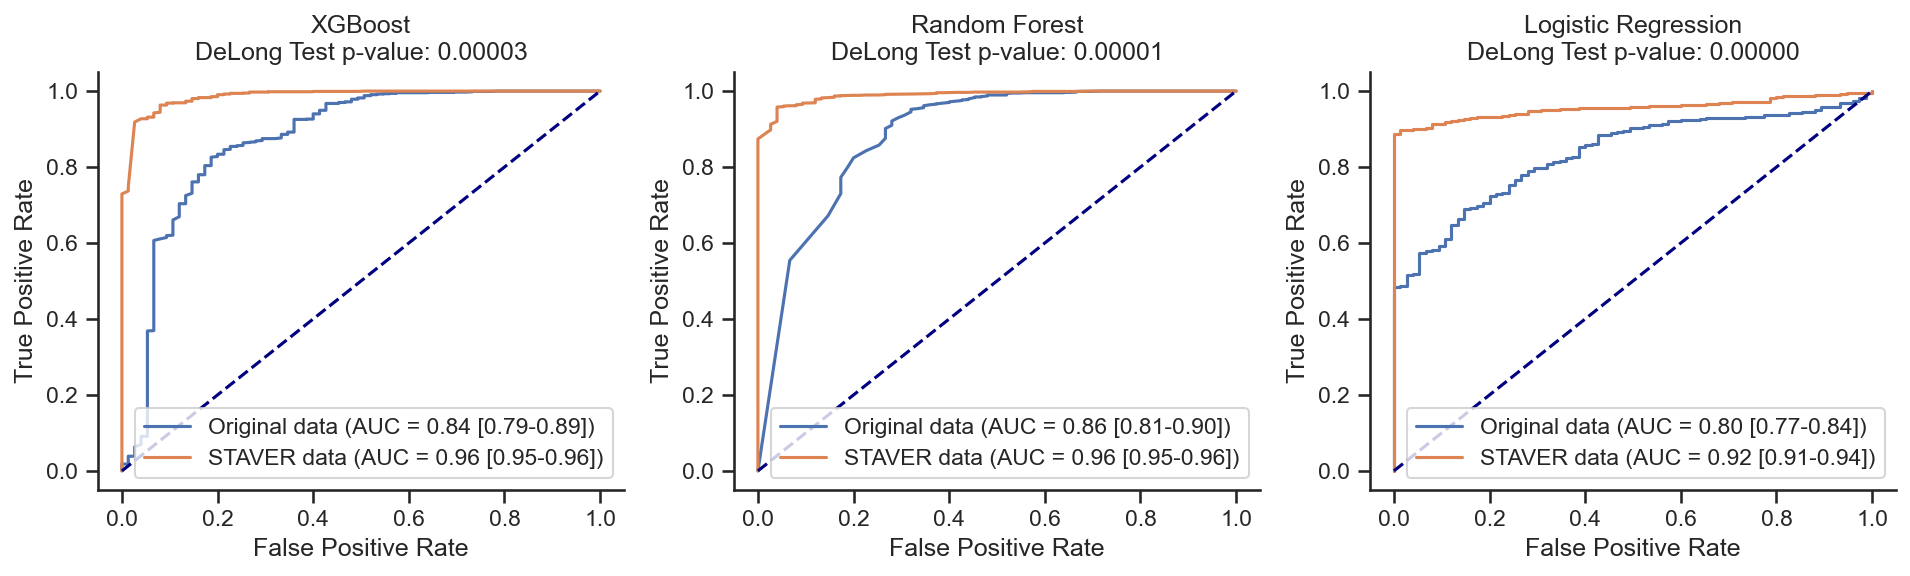

In [66]:
STAVER_model, raw_data_model = load_data(target="Cancer_type", 
                                        genes=["HSPA4","GGT1","DCP","A1CF"], 
                                        cancer_types=["Hepatocellular Carcinoma"],
                                        )

outpath = "~/DIA-STAVER/949-cell-lines-1/model-evaluate/benchmark_models_based_on_HCC_markers.pdf"
evaluator = ModelEvaluator(raw_data_model, STAVER_model, 
                            target='Cancer_type',
                            k_fold=5,
                            random_state=42,
                            auc_scale = 0.03,
                            outpath=outpath
                            )
evaluator.train_models()
evaluator.plot_rocs()

z score = -4.19364;
p value = 0.00003;
There is a significant difference
Confusion Matrix of XGBoost on Dataset 1:
[[  36   39]
 [  11 1156]]


z score = -4.19364;
p value = 0.00003;
There is a significant difference
Confusion Matrix of XGBoost on Dataset 2:
[[  59   16]
 [  11 1156]]


z score = -4.74088;
p value = 0.00000;
There is a significant difference
Confusion Matrix of Random Forest on Dataset 1:
[[  33   42]
 [   6 1161]]


z score = -4.74088;
p value = 0.00000;
There is a significant difference
Confusion Matrix of Random Forest on Dataset 2:
[[  60   15]
 [  14 1153]]


z score = -7.61224;
p value = 0.00000;
There is a significant difference
Confusion Matrix of Logistic Regression on Dataset 1:
[[   0   75]
 [   2 1165]]


z score = -7.61224;
p value = 0.00000;
There is a significant difference
Confusion Matrix of Logistic Regression on Dataset 2:
[[  16   59]
 [  30 1137]]




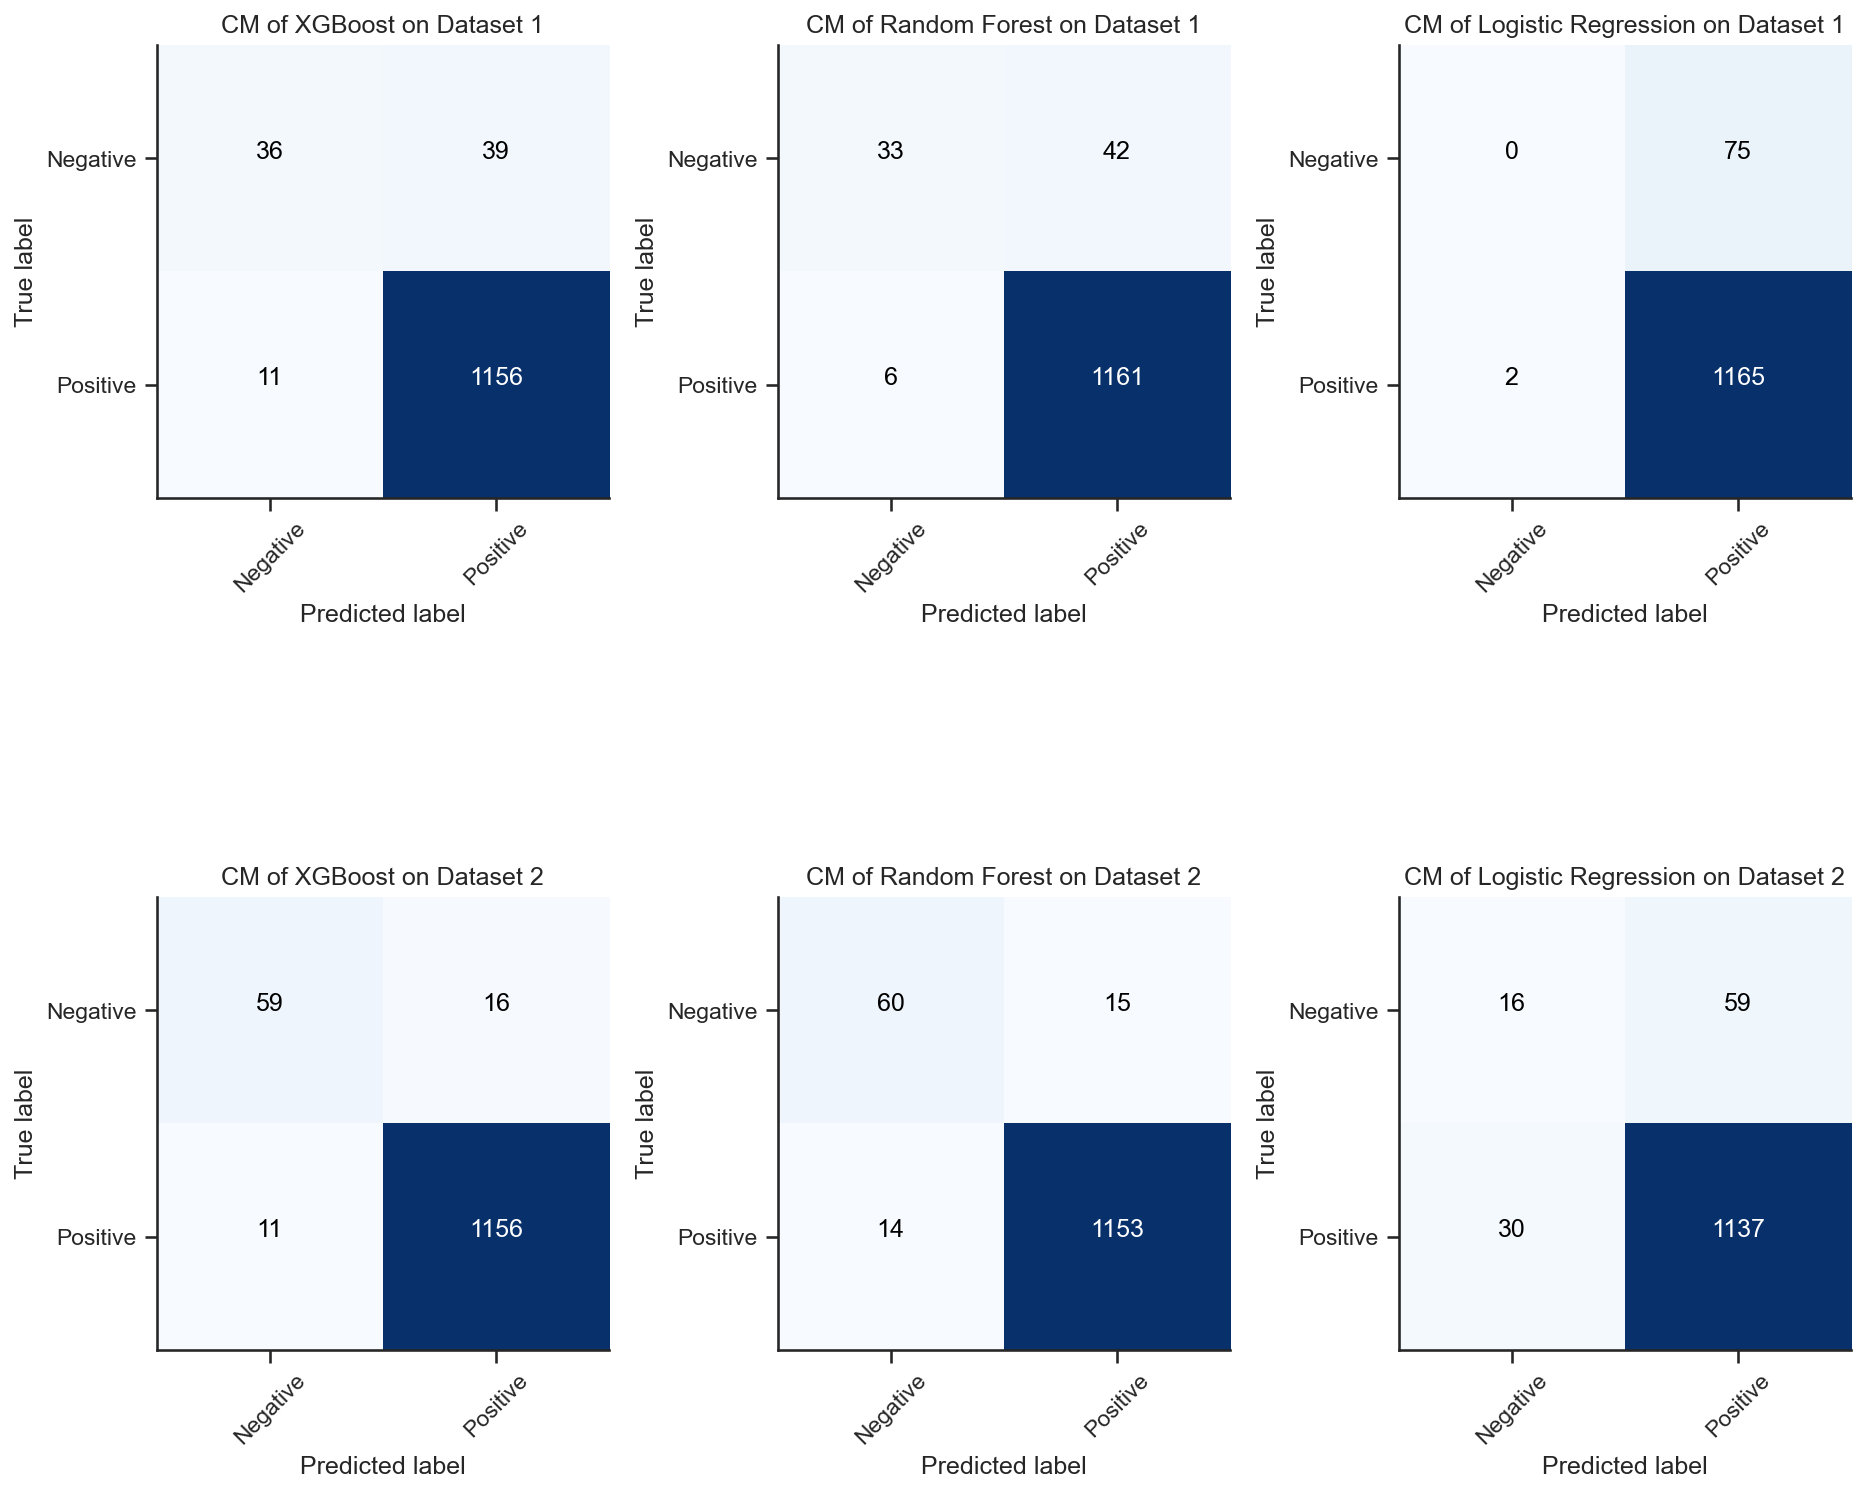

In [92]:
STAVER_model, raw_data_model = load_data(target="Cancer_type", 
                                        genes=["HSPA4","GGT1","DCP","A1CF"], 
                                        cancer_types=["Hepatocellular Carcinoma"], 
                                        )

outpath = "~/DIA-STAVER/949-cell-lines-1/model-evaluate/benchmark_models_based_on_HCC_markers_CM.pdf"
evaluator = ModelEvaluator_CM(raw_data_model, STAVER_model, 
                            target='Cancer_type',
                            k_fold=5,
                            random_state=42,
                            outpath=outpath
                            )
evaluator.train_models()
evaluator.plot_rocs()

### Gastric Carcinoma biomarkers

XGBoost on Original data: AUC = 0.86 (0.82-0.89)
XGBoost on STAVER data: AUC = 0.95 (0.93-0.96)
z score = -5.33799;
p value = 0.00000;
There is a significant difference


Random Forest on Original data: AUC = 0.85 (0.82-0.88)
Random Forest on STAVER data: AUC = 0.94 (0.92-0.95)
z score = -4.22570;
p value = 0.00002;
There is a significant difference


Logistic Regression on Original data: AUC = 0.77 (0.73-0.80)
Logistic Regression on STAVER data: AUC = 0.93 (0.91-0.94)
z score = -9.25535;
p value = 0.00000;
There is a significant difference




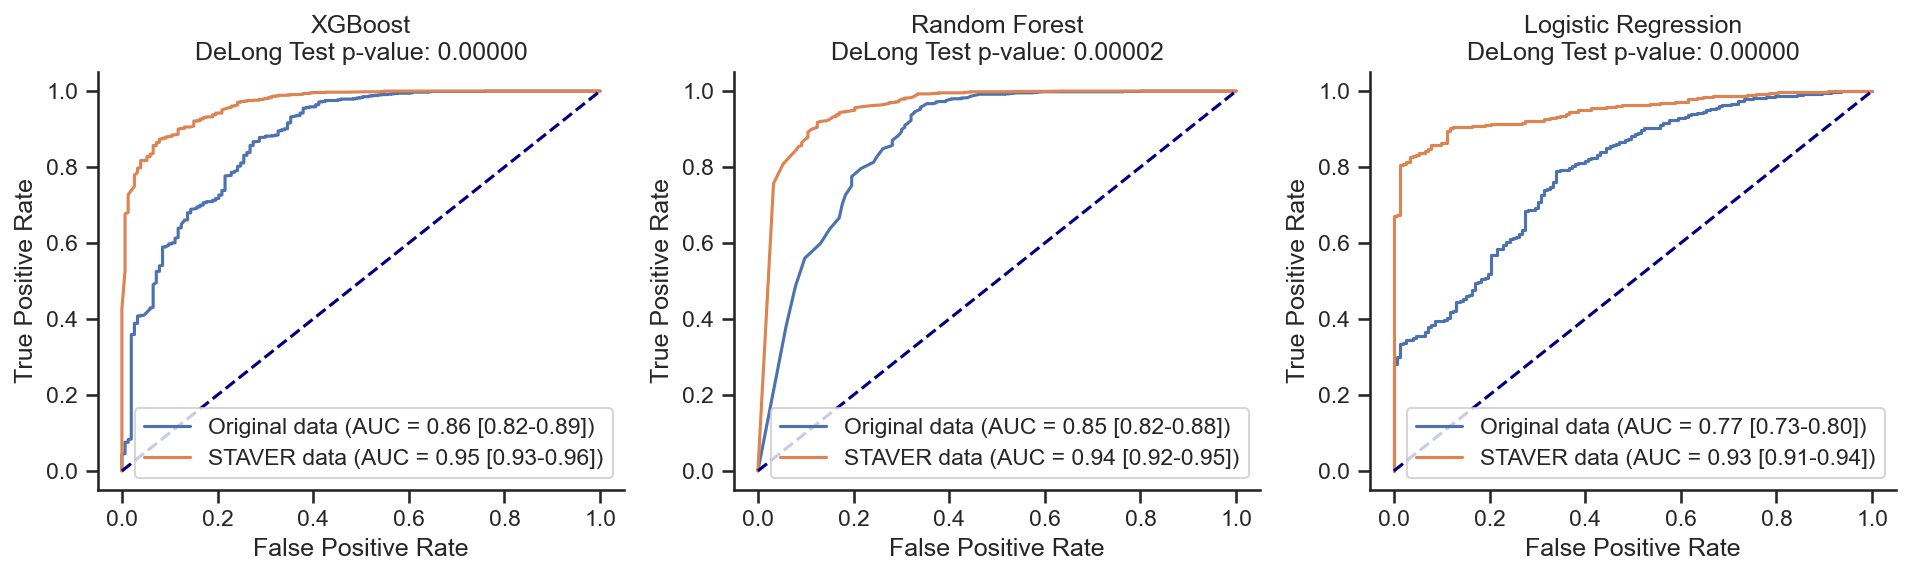

In [67]:
STAVER_model, raw_data_model = load_data(target="Cancer_type", 
                                        genes=["ERBB2","AGR3","AKR7A3","CTSE"], 
                                        cancer_types=["Gastric Carcinoma"], 
                                        )

outpath = "~/DIA-STAVER/949-cell-lines-1/model-evaluate/benchmark_models_based_on_Gastric_markers.pdf"
evaluator = ModelEvaluator(raw_data_model, STAVER_model,
                            target='Cancer_type',
                            k_fold=5,
                            random_state=42,
                            auc_scale=0.02,
                            outpath=outpath
                            )
evaluator.train_models()
evaluator.plot_rocs()

### Colorectal Carcinoma biomarkers

XGBoost on Original data: AUC = 0.85 (0.81-0.88)
XGBoost on STAVER data: AUC = 0.88 (0.86-0.91)
z score = -2.69639;
p value = 0.00701;
There is a significant difference


Random Forest on Original data: AUC = 0.84 (0.81-0.87)
Random Forest on STAVER data: AUC = 0.89 (0.86-0.92)
z score = -4.33362;
p value = 0.00001;
There is a significant difference


Logistic Regression on Original data: AUC = 0.84 (0.81-0.87)
Logistic Regression on STAVER data: AUC = 0.88 (0.86-0.91)
z score = -3.80086;
p value = 0.00014;
There is a significant difference




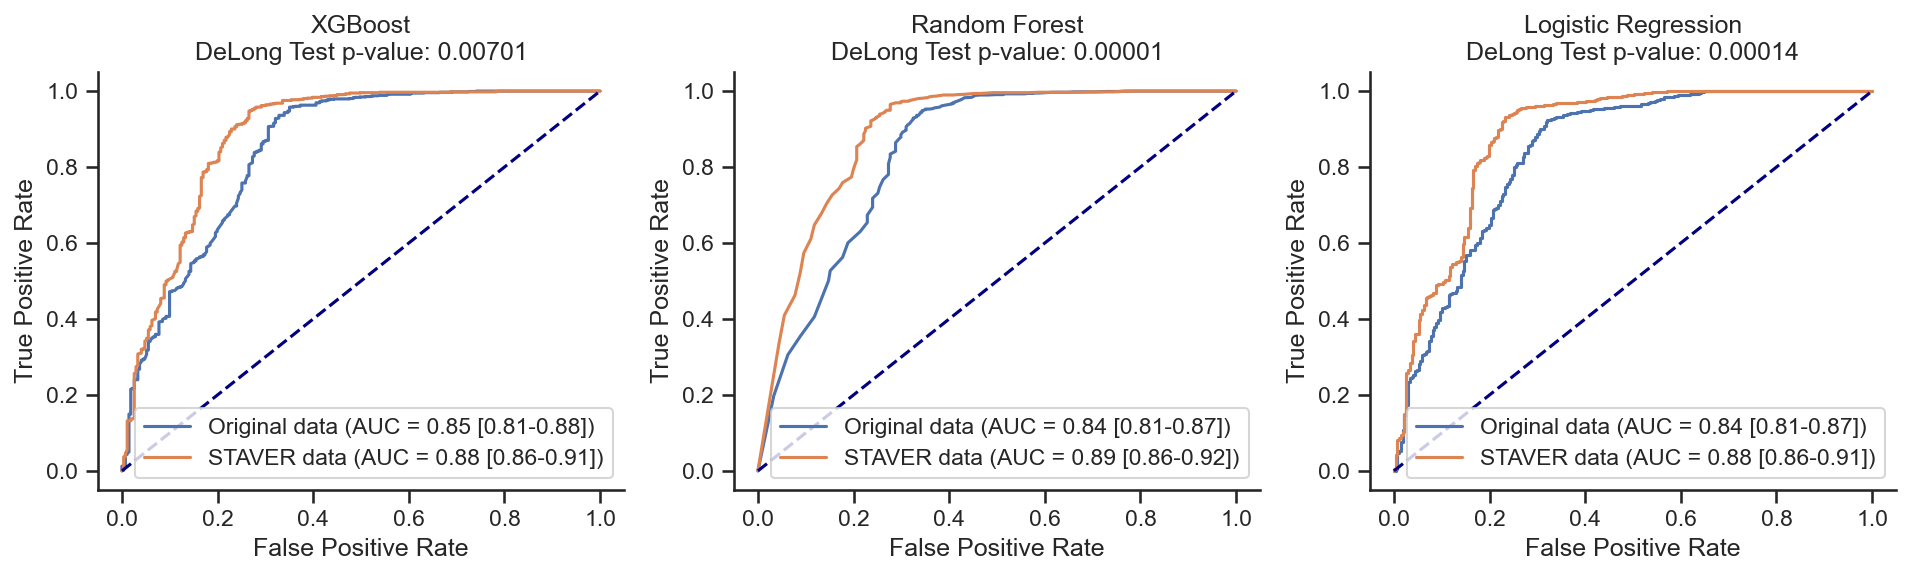

In [70]:
STAVER_model, raw_data_model = load_data(target="Cancer_type", 
                                        genes=["MUC2", "EPCAM", "CDX2", "MUC13"], 
                                        cancer_types=["Colorectal Carcinoma"])

outpath = "~/DIA-STAVER/949-cell-lines-1/model-evaluate/benchmark_models_based_on_CRC_markers.pdf"
evaluator = ModelEvaluator(raw_data_model, STAVER_model,
                            target='Cancer_type',
                            k_fold=5,
                            random_state=42,
                            outpath=outpath
                            )
evaluator.train_models()
evaluator.plot_rocs()

### NSCLC vs. SCLC (NSCLC and SCLC biomarkers)

XGBoost on Original data: AUC = 0.82 (0.78-0.87)
XGBoost on STAVER data: AUC = 0.91 (0.86-0.94)
z score = -2.71389;
p value = 0.00665;
There is a significant difference


Random Forest on Original data: AUC = 0.80 (0.74-0.85)
Random Forest on STAVER data: AUC = 0.95 (0.92-0.96)
z score = -5.21232;
p value = 0.00000;
There is a significant difference


Logistic Regression on Original data: AUC = 0.85 (0.81-0.89)
Logistic Regression on STAVER data: AUC = 0.94 (0.91-0.96)
z score = -3.96235;
p value = 0.00007;
There is a significant difference




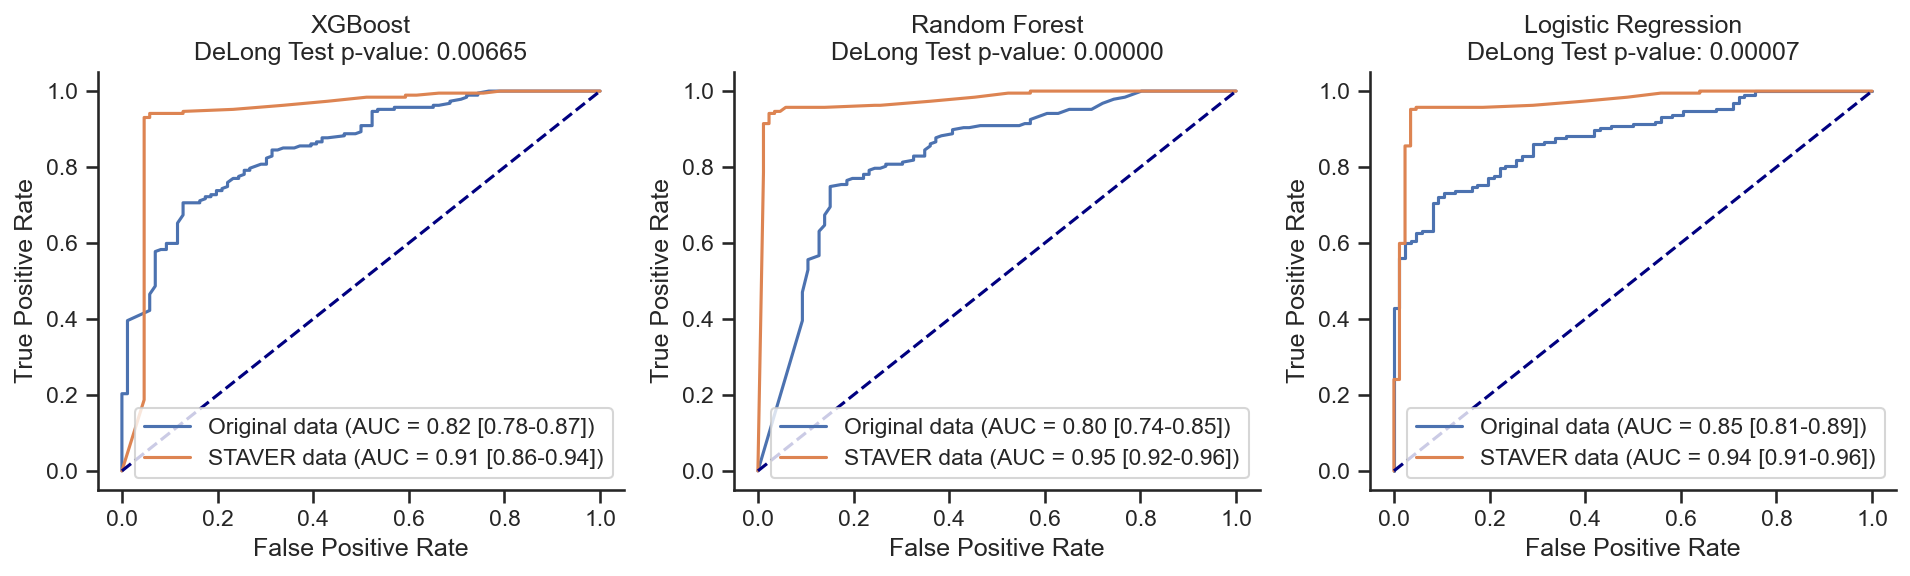

In [72]:
STAVER_model, raw_data_model = load_data(target="Cancer_type", 
                                         genes=["KRT5", "DSC3", "CHGA", "NCAM1", "SYP", "GRP"], 
                                         cancer_types=["Small Cell Lung Carcinoma", "Non-Small Cell Lung Carcinoma"])

outpath = "~/DIA-STAVER/949-cell-lines-1/model-evaluate/benchmark_models_based_on_lung_markers.pdf"

evaluator = ModelEvaluator(raw_data_model, STAVER_model, 
                            target='Cancer_type',
                            k_fold=5,
                            random_state=42,
                            auc_scale=0.03,
                            outpath=outpath
                            )
evaluator.train_models()
evaluator.plot_rocs()

### Glioma biomarkers

In [ ]:
STAVER_model, raw_data_model = load_data(target="Cancer_type", 
                                         genes=["GFAP","NES"], 
                                         cancer_types=["Glioma"])

outpath = "~/DIA-STAVER/949-cell-lines-1/model-evaluate/benchmark_models_based_on_glioma_markers.pdf"
evaluator = ModelEvaluator(raw_data_model, STAVER_model,
                            target='Cancer_type',
                            k_fold=5,
                            random_state=42,
                            outpath=outpath,
                            )
evaluator.train_models()
evaluator.plot_rocs()

### Pancreatic Carcinoma biomarkers

XGBoost on Original data: AUC = 0.80 (0.75-0.85)
XGBoost on STAVER data: AUC = 0.88 (0.84-0.92)
z score = -2.80131;
p value = 0.00509;
There is a significant difference


Random Forest on Original data: AUC = 0.79 (0.74-0.84)
Random Forest on STAVER data: AUC = 0.88 (0.83-0.91)
z score = -3.26500;
p value = 0.00109;
There is a significant difference


Logistic Regression on Original data: AUC = 0.76 (0.70-0.82)
Logistic Regression on STAVER data: AUC = 0.85 (0.80-0.89)
z score = -4.05580;
p value = 0.00005;
There is a significant difference




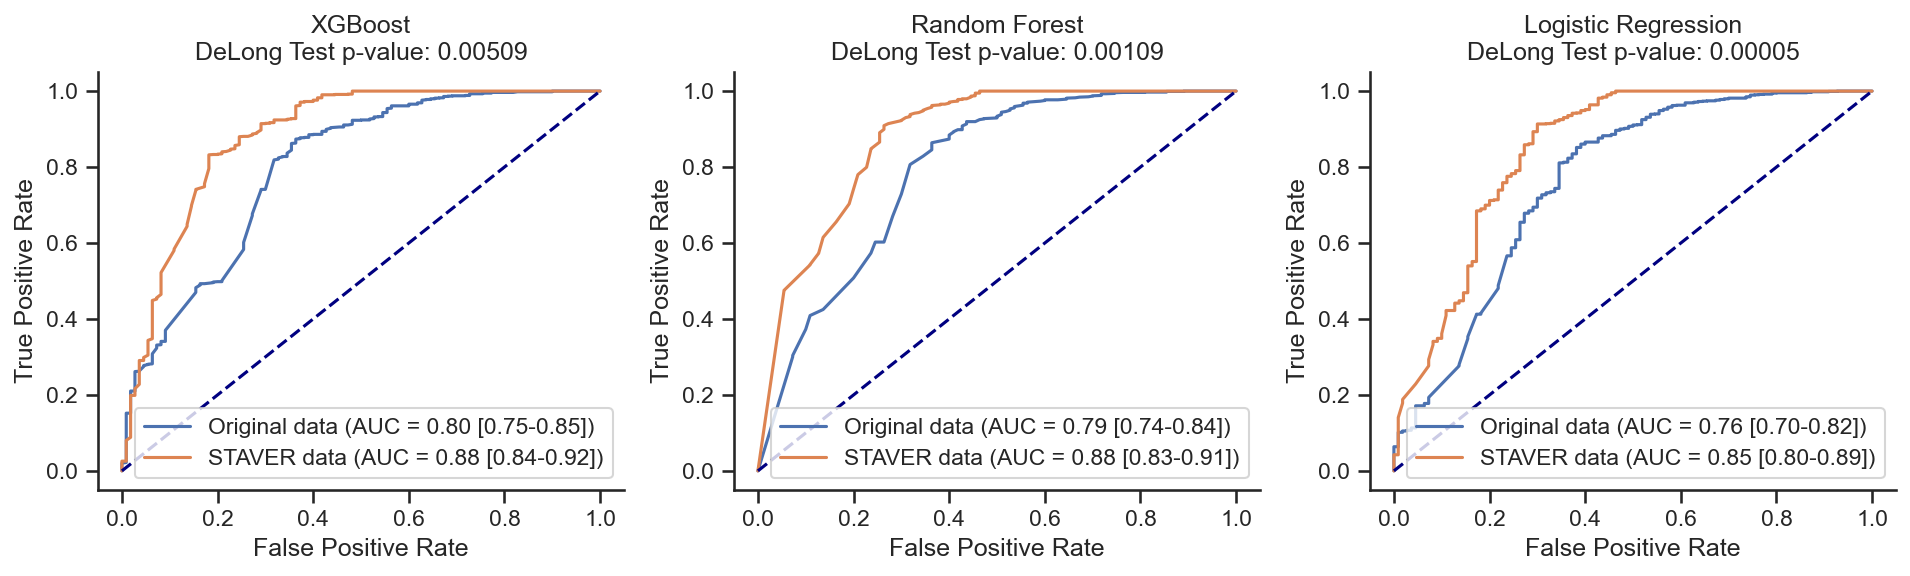

In [77]:
STAVER_model, raw_data_model = load_data(target="Cancer_type", 
                                         genes=["MUC1", "ANO1", "DHRS9", "S100P"], 
                                         cancer_types=["Pancreatic Carcinoma"])

outpath = "~/DIA-STAVER/949-cell-lines-1/model-evaluate/benchmark_models_based_on_PDAC_markers.pdf"
evaluator = ModelEvaluator(raw_data_model, STAVER_model, 
                            target='Cancer_type',
                            k_fold=5,
                            random_state=42,
                            outpath=outpath
                            )
evaluator.train_models()
evaluator.plot_rocs()